<a href="https://colab.research.google.com/github/pedrohenriquecordeiro/machine-learning-model-optimization/blob/master/Otimizando.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Como escolher o melhor modelo

#### Download do dataset



Cada linha dos dados representa um veículo à venda em um site fictício de vendas de automóveis. 

In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


Modifica o dataset para incluir o nome do modelo

In [2]:
# os nomes estão em um arquivo externo
import pandas as pd
carros = pd.read_csv('modelos-carro.csv')
carros.head()
names = []

# minera os nomes do dataset de nomes
import re
re1 = '.*?'	# Non-greedy match on filler
re2 = '((?:[a-z][a-z]+))'	# Word 1
rg = re.compile(re1+re2,re.IGNORECASE|re.DOTALL)

for index, row in carros.iterrows():
    text = row['ID;IDMARCA;NOME']
    m = rg.search(text)
    if m:
      name = m.group(1)
      names.append(name)

# mistura os nomes
from random import shuffle
shuffle(names)

# adiciona os nomes ao dataset de carros
import numpy as np
# usamos uma faixa de valores para os modelos 
# serem mais organicos dentro do dataset de carros
num_sorteados = np.clip(
    dados.idade_do_modelo + np.random.randint(-10 ,10 + 1 , size = len(dados)),
    0,
    len(names))

# cria lista com os carros sorteados
carros_sorteados = [names[i] for i in num_sorteados]

# cria a nova coluna
dados['modelo'] = carros_sorteados
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,GRAND
1,40557.96,1,20,12622.05362,XL
2,89627.50,0,12,11440.79806,SL
3,95276.14,0,3,43167.32682,IBIZA
4,117384.68,1,4,12770.11290,CROSSFIRE


#### Efetua a validação usando arvore de decisão

In [3]:
# separa os dados - caracteristicas , marcacoes
x = dados[["preco", "idade_do_modelo","km_por_ano"]]
y = dados["vendido"]

# fixa o parametro de aleatoriedade
SEED = 301
np.random.seed(SEED)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate

scaler = StandardScaler()
modelo = DecisionTreeClassifier(max_depth = 2)

pipeline = Pipeline([('transformacao', scaler), ('estimador', modelo)])

# determina o numero de validações cruzadas do cross validate
cv = GroupKFold(n_splits = 10)

# faz a validacao cruzada
results = cross_validate(pipeline, 
                         x,y, 
                         cv = cv, 
                         # agrupa os dados a partir dos 
                         # modelos existentes no dataset
                         groups = dados.modelo, 
                         return_train_score = False)

media = results ['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy mean: %.2f%%" % (media * 100))
print("Accuracy [%.2f%%, %.2f%%]" % 
      ((media - 2 *desvio_padrao) * 100, 
       (media + 2 * desvio_padrao) * 100))

Accuracy mean: 75.80%
Accuracy [72.70%, 78.90%]


Agora de fato treinamos o modelo

In [4]:
# treinamento normal
modelo.fit(x,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

#### Imprime a arvore de decisão criada

!pip install graphviz==0.9

!pip install pydot

!apt-get install graphviz

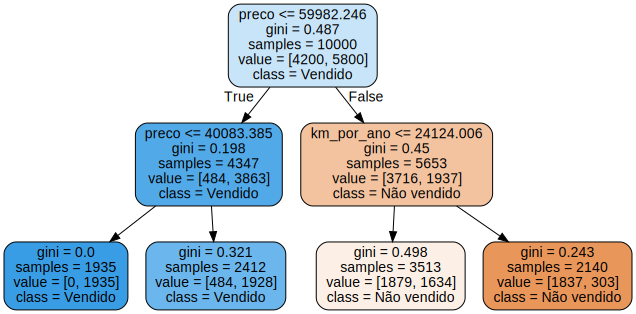

In [5]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(modelo, out_file = None, filled = True,
               rounded = True , class_names = ["Não vendido","Vendido"],
               feature_names = x.columns)

tree = graphviz.Source(dot_data)
tree

# 1 - Testa o hiperparâmetro max_depth

In [6]:
result = []

def test(max_depth):
  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x, y,
                           cv = cv, 
                           groups = dados.modelo, 
                           return_train_score = True)
    
  # salva os resultados
  result.append(
      [
        max_depth,
        results['fit_time'].mean(),
        results['score_time'].mean(),
        results['train_score'].mean() * 100,
        results['test_score'].mean() * 100
      ])
  
  
for i in range (1, 15 + 1):
      test(i)

result = pd.DataFrame(result , 
                      columns = [ 'max_depth', 'fit_time', 'score_time', 'train_score' , 'test_score'])

result.head()

,max_depth,fit_time,score_time,train_score,test_score
0,1,0.005769,0.001339,75.791408,75.804150
1,2,0.008036,0.001335,75.791408,75.804150
2,3,0.010254,0.001422,78.752570,78.708432
3,4,0.011661,0.001413,78.798124,78.688203
4,5,0.013532,0.001365,78.946939,78.697424


#### Plota o resultado (overfit)
!pip install seaborn==0.9.0

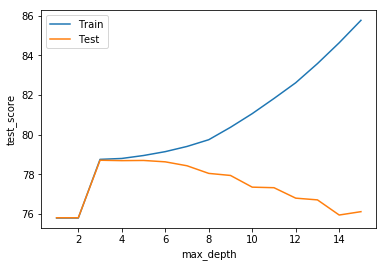

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(x = 'max_depth' , y = 'train_score' , data = result)
sns.lineplot(x = 'max_depth' , y = 'test_score' , data = result)
plt.legend(["Train",'Test'])

#### Qual o melhor valor de max_depth para o test ?

In [8]:
result.sort_values('test_score' , ascending = False).head()

,max_depth,fit_time,score_time,train_score,test_score
2,3,0.010254,0.001422,78.752570,78.708432
4,5,0.013532,0.001365,78.946939,78.697424
3,4,0.011661,0.001413,78.798124,78.688203
5,6,0.015776,0.001475,79.142539,78.627739
6,7,0.016847,0.001515,79.404805,78.428865


# 2 - Testa os Hiperparâmetros max_depth e o min_samples_leaf

In [9]:
result = []

def test(max_depth,min_samples_leaf):
  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(
      max_depth = max_depth,
      min_samples_leaf = min_samples_leaf)
  results = cross_validate(modelo, x, y,
                           cv = cv, 
                           groups = dados.modelo, 
                           return_train_score = True)
    
  # salva os resultados
  result.append(
      [
        max_depth,
        min_samples_leaf,
        results['fit_time'].mean(),
        results['score_time'].mean(),
        results['train_score'].mean() * 100,
        results['test_score'].mean() * 100
      ])
  
  
for depth in range (1, 15 + 1):
  for min_leaf in range (1, 15 + 1):
      test(depth,min_leaf)

result = pd.DataFrame(result , 
                      columns = [ 'max_depth', 'min_samples_leaf', 'fit_time', 'score_time', 'train_score' , 'test_score'])

# mostra os melhores resultados
result.sort_values('test_score' , ascending = False).head()

,max_depth,min_samples_leaf,fit_time,score_time,train_score,test_score
61,5,2,0.013383,0.001357,78.924728,78.717605
35,3,6,0.009761,0.001339,78.752570,78.708432
44,3,15,0.009827,0.001343,78.752570,78.708432
42,3,13,0.009806,0.001335,78.752570,78.708432
41,3,12,0.009747,0.001331,78.752570,78.708432


#### Correlação dos Resultados

In [10]:
corr = result.corr()
corr

,max_depth,min_samples_leaf,fit_time,score_time,train_score,test_score
max_depth,1.000000,0.000000,0.987894,0.484522,0.935455,-0.357612
min_samples_leaf,0.000000,1.000000,-0.055317,-0.071035,-0.108027,-0.023043
fit_time,0.987894,-0.055317,1.000000,0.515706,0.947149,-0.271443
score_time,0.484522,-0.071035,0.515706,1.000000,0.429756,-0.170111
train_score,0.935455,-0.108027,0.947149,0.429756,1.000000,-0.124719
test_score,-0.357612,-0.023043,-0.271443,-0.170111,-0.124719,1.000000


Quanto mais alto o valor, mais correlacionados estão os elementos na comparação. Por exemplo, quanto maior o max_depth, maior será o max_depth. Essa é uma conclusão bastante óbvia, afinal o max_depth é ele mesmo, mas que nos ajuda a entender o que está acontecendo. Além disso, repare resultados positivos (maiores que 0) representam uma correlação positiva, e negativos uma correlação negativa.

Outras conclusões que podemos tirar a partir desses resultados:

* quando max_depth cresce, o treino parece crescer também
* quando min_samples_leaf cresce, o treino cai
* quando max_depth sobe, o teste cai
* quando min_samples_leaf sobe, o teste sobe

####Note que essa não é uma prova de causalidade, mas um teste de correlação.

# 3 - Visualiza a correlação do resultado

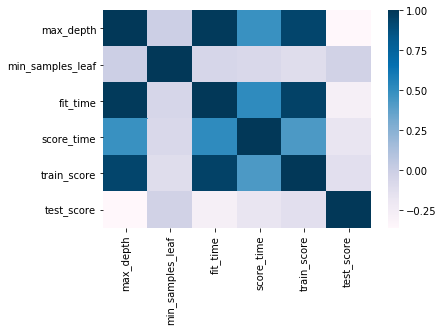

In [11]:
sns.heatmap(corr,cmap = "PuBu")

# 4 - Explorando Hiperparâmetros como o gridsearch

In [12]:
from sklearn.model_selection import GridSearchCV

paramets = {
    "max_depth" : [2, 3, 4, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

search = GridSearchCV(DecisionTreeClassifier(),
                    paramets,
                    cv = GroupKFold(n_splits = 10))

search.fit(x, y ,groups = dados.modelo)
results = pd.DataFrame(search.cv_results_)
r = results.sort_values('mean_test_score',ascending = False)
# mostra o melhor
for id,row in r[:3].iterrows():
  print("%.3f +-(%.3f) %s" % (row.mean_test_score, row.std_test_score*2, row.params))
  break

0.787 +-(0.032) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 128, 'min_samples_split': 128}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


 #### os melhores parâmetros

In [13]:
search.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 32,
 'min_samples_split': 32}

#### melhor score

In [14]:
search.best_score_ * 100

78.68

#### pegamos o melhor modelo já treinado e fazemos a avaliação

Na documentação do SKLearn, encontramos uma seção sobre nested versus non-nested cross-validation. O texto afirma que quando estamos utilizando hiperparâmetros, fazendo, por exemplo, o GridSearchCV junto com o cross_validation_score, não devemos descobrir a nossa métrica por meio do predict(), mas sim com outro cross_valiation_score.

Utilizar o predict() acaba sendo muito otimista, pois acabamos incorrendo em um vício sobre os dados que já tínhamos visto. Portanto, essa abordagem deve ser evitada.

```
from sklearn.model_selection import cross_val_score

scores = cross_val_score(search, x, y , cv = GroupKFold(n_splits=10), groups = dados.modelo)
scores

```



Tentando rodar esse código, receberemos um erro afirmando que o valor de groups não deve ser none, como se não tivéssemos passado nenhum valor para os grupos. Ou seja, de alguma forma groups não está chegando em GroupKFold() - e é exatamente isso que está acontecendo.

Na verdade, isso ocorre por conta de um bug - o GroupKFold falha na validação cruzada aninhada, e existe até um tópico no GitHub do scikit sobre esse problema. É um bug antigo (o tópico foi criado em 2016), mas continua em aberto, pois é razoavelmente complicado implementar a correção dele.

Como o Pandas não suporta nested validation com o GroupKFold, não conseguiremos prever o resultado para novos grupos. Como alternativa, usaremos o KFold comum, que precisa ser importado de sklearn.model_selection.

In [15]:
# repete essa parte do codigo - mas agora com o KFold e sem o groups
from sklearn.model_selection import KFold

paramets = {
    "max_depth" : [2, 3, 4, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

search = GridSearchCV(DecisionTreeClassifier(),
                    paramets,
                    cv = KFold(n_splits = 10))

search.fit(x, y)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(search, x, y, cv = KFold(n_splits = 10, shuffle=True) )
scores

array([0.796, 0.772, 0.785, 0.79 , 0.792, 0.789, 0.78 , 0.823, 0.766,
       0.776])

In [16]:
media = scores.mean() * 100
desvio = scores.std() * 100
print("Accuracy média %.2f" % media)
print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Accuracy média 78.69
Intervalo [75.69, 81.69]


#### seleciona o melhor models

In [17]:
better = search.best_estimator_
better

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

#### Imprime a arvore de descisão

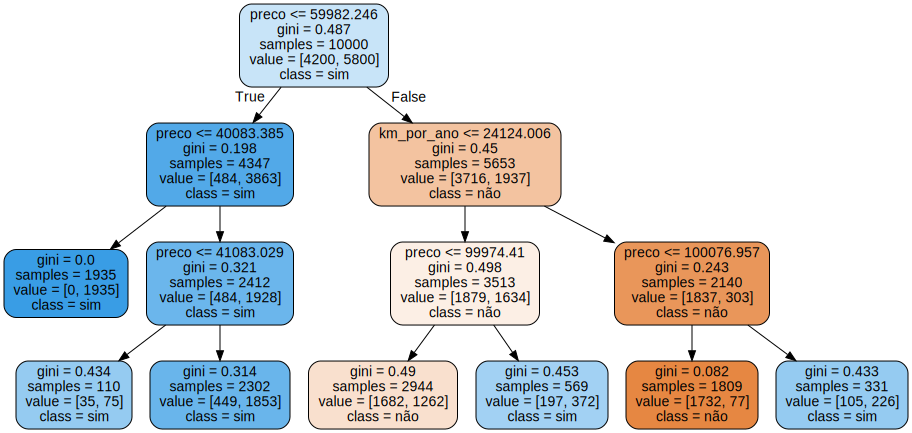

In [18]:
from sklearn.tree import export_graphviz
import graphviz


features = x.columns
dot_data = export_graphviz(better, out_file = None, filled = True, rounded = True,
                          class_names=["não","sim"],
                          feature_names = features )
graph = graphviz.Source(dot_data)
graph

# 5 - Explorando Hiperparâmetros como o Randomsearch

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

paramets = {
    "max_depth" : [2, 3, 4, 5 , None],
    "min_samples_split": randint(32,128),
    "min_samples_leaf": randint(32,128),
    "criterion": ["gini", "entropy"]

}

search = RandomizedSearchCV(DecisionTreeClassifier(),
                    paramets,
                    n_iter = 16,
                    cv = KFold(n_splits = 10),
                    random_state = SEED)

search.fit(x, y)

# nested cross validate
from sklearn.model_selection import cross_val_score

scores = cross_val_score(search, x, y, cv = KFold(n_splits = 10, shuffle=True) )

media = scores.mean() * 100
desvio = scores.std() * 100
print("Accuracy média %.2f" % media)
print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Accuracy média 78.69
Intervalo [74.95, 82.43]


In [20]:
better = search.best_estimator_
better

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=73, min_samples_split=72,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')